In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch

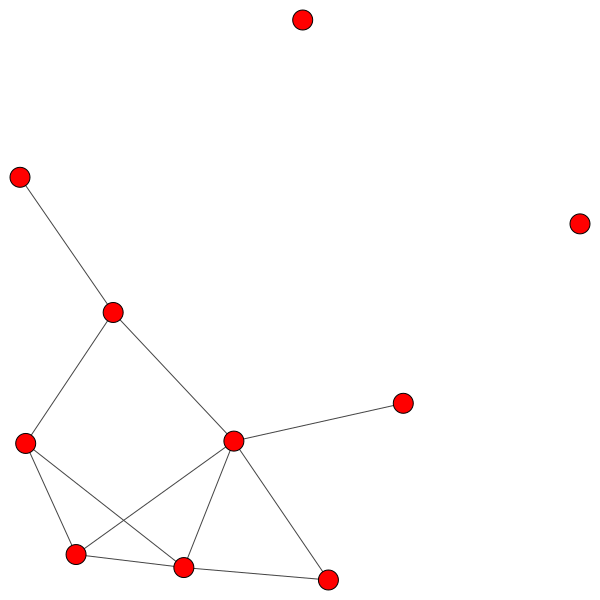

In [96]:
g = ig.Graph.Erdos_Renyi(n = 10, m = 11)
layout = g.layout('kk')
ig.plot(g, layout = layout)

In [97]:
adjM = torch.autograd.Variable(torch.Tensor(g.get_adjacency().data), requires_grad = True)
N = adjM.shape[0]

# get Laplacian
L = torch.diag(torch.matmul(adjM, torch.ones(N))) - adjM
L_mod = L + torch.ones_like(L)/N

# calculate log dets
eps = 10e-6
print(-torch.logdet(L_mod))
print(-torch.logdet(L_mod + eps * torch.eye(N)))

tensor(inf, grad_fn=<NegBackward>)
tensor(16.8405, grad_fn=<NegBackward>)


In [98]:
torch.det(L_mod)

tensor(0., grad_fn=<DetBackward>)

# Implement on our dataset

In [123]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES, get_bt_index

from mol_opt.mol_opt import MolOpt
from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main, get_latest_model
from mol_opt.ot_utils import encode_target, FGW, Penalty

from rdkit.Chem import MolFromSmiles

import torch
from torch import nn
import numpy as np
import time

/home/octav/gitrepos/tum-thesis
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
data_loader = get_loader("iclr19-graph2graph/data/qed", "val", 96, False)
for i in data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

In [176]:
sys.argv = ["", "-cuda"]
args = get_args()
args.output_dir = "mol_opt/output/"

mol_opt = MolOpt(args)
mol_opt_decoder = MolOptDecoder(args)
loss = FGW(alpha = 0.5)

In [126]:
x_embedding, x_delta_hat = mol_opt.forward(X)
yhat_embedding = x_embedding + x_delta_hat
yhat_logits = mol_opt_decoder.forward(yhat_embedding, Y)
yhat_labels = mol_opt_decoder.discretize(*yhat_logits)

pred_pack = (yhat_labels, yhat_logits, Y.scope), Y
loss(*pred_pack).item() / 96

3.9284454981486

In [177]:
loss(*pred_pack)

tensor([[[1.4475, 1.4952, 1.5972, 1.6081, 1.9811],
         [1.4704, 1.4572, 1.6036, 1.6494, 1.9384],
         [1.4597, 1.4890, 1.5800, 1.6491, 1.9386],
         ...,
         [1.4925, 1.4767, 1.5328, 1.6879, 1.9245],
         [1.4903, 1.5252, 1.5346, 1.6160, 1.9457],
         [1.4720, 1.4965, 1.5149, 1.6838, 1.9582]],

        [[1.4704, 1.4572, 1.6036, 1.6494, 1.9384],
         [1.4578, 1.4504, 1.6220, 1.6865, 1.8964],
         [1.4670, 1.4519, 1.6187, 1.6727, 1.9014],
         ...,
         [1.4980, 1.4536, 1.5355, 1.7377, 1.8878],
         [1.5056, 1.4817, 1.5517, 1.6461, 1.9231],
         [1.4901, 1.4428, 1.5473, 1.7056, 1.9386]],

        [[1.4597, 1.4890, 1.5800, 1.6491, 1.9386],
         [1.4670, 1.4519, 1.6187, 1.6727, 1.9014],
         [1.4731, 1.4495, 1.6059, 1.6871, 1.8949],
         ...,
         [1.4940, 1.4757, 1.5199, 1.7161, 1.9078],
         [1.4890, 1.5136, 1.5446, 1.6427, 1.9143],
         [1.4738, 1.4779, 1.5288, 1.7063, 1.9344]],

        ...,

        [[1.4925, 1.

In [115]:
symbols_logits, charges_logits, bonds_logits = yhat_logits

In [120]:
bonds_logits.shape

torch.Size([44494, 5])

In [194]:
pen = Penalty()

In [198]:
pen.conn(*pred_pack).item() / 96

-23.408793131510418

In [183]:
bond_idx = 0
num_atoms = 22
adjM = bonds_soft[bond_idx:bond_idx+num_atoms*num_atoms].view(num_atoms, num_atoms, -1)

In [184]:
adjM.sum(axis = 2)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.000

In [158]:
adjM[0,1,:]

tensor([1.5057, 1.4681, 1.5239, 1.7426, 1.8653], device='cuda:0',
       grad_fn=<SliceBackward>)

In [160]:
adjM.shape

torch.Size([22, 22, 5])

In [163]:
bonds_soft.shape

torch.Size([44494, 5])

In [180]:
bonds_logits[0,:]

tensor([ 0.1937,  0.1839,  0.1660, -0.0629, -0.1889], device='cuda:0',
       grad_fn=<SliceBackward>)

In [191]:
bonds_soft[:,-1]

tensor([0.1544, 0.1548, 0.1487,  ..., 0.1446, 0.1421, 0.1404], device='cuda:0',
       grad_fn=<SelectBackward>)

In [178]:
bonds_soft = nn.Softmax(dim=1)(bonds_logits)